# Downloading and Comparing Observed and Synthetic Data

In [1]:
%matplotlib inline
from obspy.clients.fdsn.client import Client
from obspy.clients.fdsn.mass_downloader import GlobalDomain
from obspy.clients.fdsn.mass_downloader import MassDownloader
from obspy.clients.fdsn.mass_downloader import Restrictions
from obspy import UTCDateTime
from obspy.geodetics import calc_vincenty_inverse
from obspy.geodetics import locations2degrees

from obspy.signal.invsim import cosine_sac_taper
from obspy.signal.util import _npts2nfft
import obspy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

import os

def reread_data():
    global synt1d, synt3d, obsd
    synt1d = obspy.read(synt1d_filename)[0]
    synt3d = obspy.read(synt3d_filename)[0]
    obsd = obspy.read(obsd_filename)[0]

## Downloading Data from ShakeMovie

> [Global ShakeMovie](http://global.shakemovie.princeton.edu/home.jsp) is Princeton University's Near Real Time Global Seismicity Portal. It has been designed to present seismologists with near real time 1D and 3D synthetic seismograms for recent earthquakes. These synthetics are the results of simulations carried out on a large computer cluster. 1D synthetic seismograms are calculated based upon normal mode summation. Movies and 3D synthetic seismograms are calculated based upon the software package SPECFEM3D_GLOBE. 


You can download movies and data for earthquakes from this website. For the purpose of this exercise we have selected September 10, 2018 Earthquake (Mw: 7.0) near KERMADEC ISLANDS ([link](http://global.shakemovie.princeton.edu/event.jsp?evid=C201809100418A)).

We have downloaded 1D and 3D synthetic seismograms for this earthquake.

In [2]:
# read synthetic data
synt1d_filename = "./C201809100418A.1D.sac/IU.ANTO.LXZ.modes.sac"
synt3d_filename = "./C201809100418A.3D.sac/IU.ANTO.MXZ.sem.sac"

synt1d = obspy.read(synt1d_filename)[0]
synt3d = obspy.read(synt3d_filename)[0]

## Downloading Event Information

You can download the HARVARD CMT SOLUTION from ShakeMovie website. Obspy also provides tools to download event information from [IRIS](https://www.iris.edu/hq/) database.

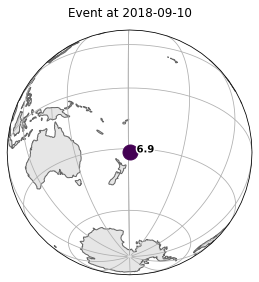

In [3]:
eqname = "C201809100418A"
quakeml_filename = "quakeml/{}.xml".format(eqname)

def download_events(force_download=False):
    if force_download or not os.path.exists(quakeml_filename):
        cl = Client()
        t1 = UTCDateTime("2018-09-10T00:00:00")
        t2 = UTCDateTime("2018-09-11T00:00:00")

        cat = cl.get_events(starttime=t1, endtime=t2, minmagnitude=6.9,
                            maxmagnitude=7.1)

        os.makedirs("quakeml", exist_ok=True)
        cat.write(quakeml_filename, "QUAKEML")
    
download_events()
cat = obspy.read_events(quakeml_filename)
cat.plot(projection="ortho", show=False)
pass

## Downloading Seismic Data

We can also download seismic recordings and instrumentation information using obspy.

In [4]:
cl = Client("IRIS")
inv = cl.get_stations(
    starttime=UTCDateTime("2018-09-10T00:00:00"), 
    endtime=UTCDateTime("2018-09-10T01:00:00"),
    matchtimeseries=True,
    channel="BH*",
    includerestricted=False,
    level="channel")

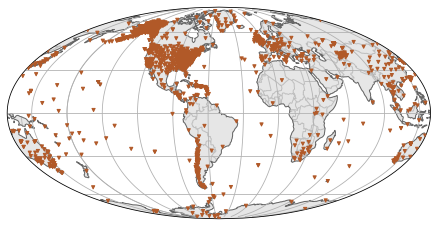

In [5]:
inv.plot(label=False, size=10);

In [6]:
def download_data(eqname, t0, lat, lon, min_length=180):
    domain = GlobalDomain()

    restrictions = Restrictions(
        # Get data for a whole year.
        starttime=t0,
        endtime=t0+60*min_length,
        # Chunk it to have one file per day.
        chunklength_in_sec=86400,
        # Considering the enormous amount of data associated with continuous
        # requests, you might want to limit the data based on SEED identifiers.
        # If the location code is specified, the location priority list is not
        # used; the same is true for the channel argument and priority list.
        network="IU", station="AN*", location="*", channel="BH*",
        # The typical use case for such a data set are noise correlations where
        # gaps are dealt with at a later stage.
        reject_channels_with_gaps=True,
        # Same is true with the minimum length. All data might be useful.
        minimum_length=0.0,
        # Guard against the same station having different names.
        minimum_interstation_distance_in_m=100.0)

    waveform_dir = "data/{}/waveforms".format(eqname)
    stationxml_dir = "data/{}/stations".format(eqname)
    os.makedirs(waveform_dir, exist_ok=True)
    os.makedirs(stationxml_dir, exist_ok=True)

    mdl = MassDownloader(providers=["IRIS"])
    mdl.download(domain, restrictions,
                 mseed_storage=waveform_dir,
                 stationxml_storage=stationxml_dir)

event = cat[0]
origin = event.preferred_origin()
download_data(eqname, origin.time-30, origin.latitude, origin.longitude)

[2020-11-16 13:06:22,493] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2020-11-16 13:06:22,578] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
[2020-11-16 13:06:22,579] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2020-11-16 13:06:22,580] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2020-11-16 13:06:22,736] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully requested availability (0.16 seconds)
[2020-11-16 13:06:22,739] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Found 2 stations (12 channels).
[2020-11-16 13:06:22,741] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Will attempt to download data from 2 stations.
[2020-11-16 13:06:22,742] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 11 time intervals/channels before downloading: EXISTS

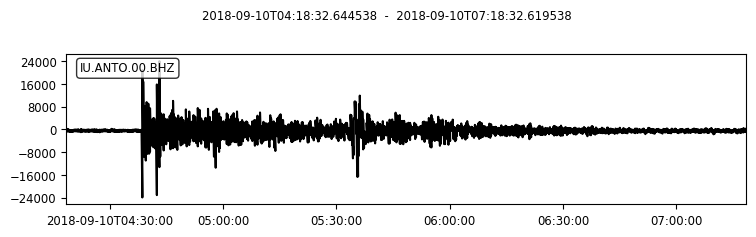

In [7]:
obsd_filename = "./data/C201809100418A/waveforms/IU.ANTO.00.BHZ__20180910T041832Z__20180910T071832Z.mseed"
obsd = obspy.read(obsd_filename)[0]
obsd.plot();

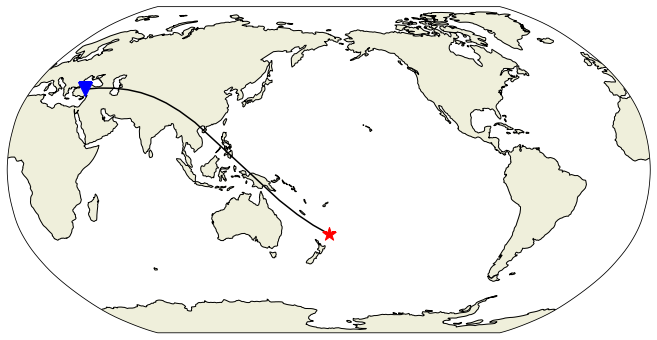

In [8]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=origin.longitude)))
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND)
inv = obspy.read_inventory("./data/C201809100418A/stations/IU.ANTO.xml")
sta_coord = inv.get_coordinates(obsd.id)

ax.scatter(origin.longitude, origin.latitude, 200, marker="*", color="red", transform=ccrs.PlateCarree(), zorder=100)
ax.scatter(sta_coord["longitude"], sta_coord["latitude"], 200, marker="v", color="blue", transform=ccrs.PlateCarree(), zorder=100)
ax.plot([origin.longitude, sta_coord["longitude"]], [origin.latitude, sta_coord["latitude"]], "k", transform=ccrs.Geodetic());

## Comparing the data

If we try to compare the observed and synthetic data without any processing, we can see that they are not similar enough.

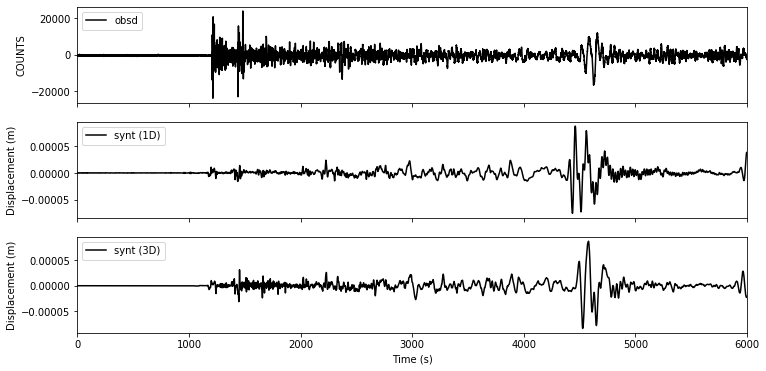

In [9]:
fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(12, 6))
axes[0].plot(obsd.times(), obsd.data, "k", label="obsd")
axes[0].legend(loc=2)
axes[0].set_ylabel("COUNTS")

axes[1].plot(synt1d.times(), synt1d.data, "k", label="synt (1D)")
axes[1].legend(loc=2)
axes[1].set_ylabel("Displacement (m)")

axes[2].plot(synt3d.times(), synt3d.data, "k", label="synt (3D)")
axes[2].set_ylabel("Displacement (m)")
axes[2].set_xlabel("Time (s)")
axes[2].set_xlim(0, 6000)

axes[2].legend(loc=2);

## Cutting and Resampling

In [10]:
traces = [obsd, synt1d, synt3d]
starts = []
ends = []
for trace in traces:
    starts.append(trace.stats.starttime)
    ends.append(trace.stats.endtime)
    print(f"{trace.id} sampling rate: {trace.stats.sampling_rate:5.2f} start: {starts[-1]} end: {ends[-1]}")    

IU.ANTO.00.BHZ sampling rate: 40.00 start: 2018-09-10T04:18:32.644538Z end: 2018-09-10T07:18:32.619538Z
IU.ANTO.S1.LXZ sampling rate:  0.50 start: 2018-09-10T04:19:06.900000Z end: 2018-09-10T05:59:04.900000Z
IU.ANTO.S3.MXZ sampling rate:  6.19 start: 2018-09-10T04:19:05.688750Z end: 2018-09-10T05:59:29.477389Z


In [11]:
traces = [obsd, synt1d, synt3d]
starttime = np.max(starts)

for trace in traces:
    trace.interpolate(0.5, starttime=starttime, npts=3000)
    
for trace in traces:
    print(f"{trace.id} sampling rate: {trace.stats.sampling_rate:5.2f} start: {starts[-1]} end: {ends[-1]}")   

IU.ANTO.00.BHZ sampling rate:  0.50 start: 2018-09-10T04:19:05.688750Z end: 2018-09-10T05:59:29.477389Z
IU.ANTO.S1.LXZ sampling rate:  0.50 start: 2018-09-10T04:19:05.688750Z end: 2018-09-10T05:59:29.477389Z
IU.ANTO.S3.MXZ sampling rate:  0.50 start: 2018-09-10T04:19:05.688750Z end: 2018-09-10T05:59:29.477389Z


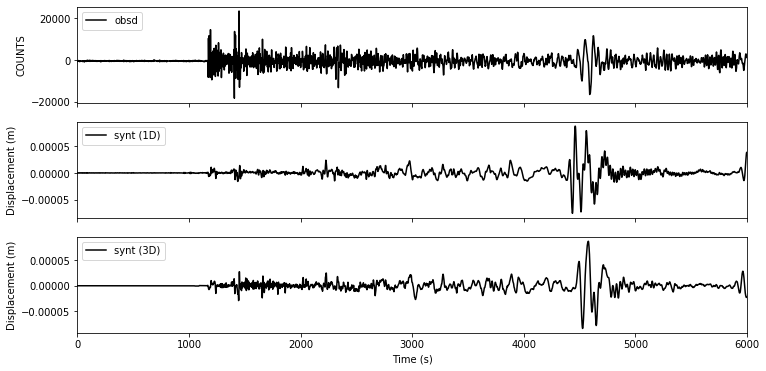

In [12]:
fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(12, 6))
axes[0].plot(obsd.times(), obsd.data, "k", label="obsd")
axes[0].legend(loc=2)
axes[0].set_ylabel("COUNTS")

axes[1].plot(synt1d.times(), synt1d.data, "k", label="synt (1D)")
axes[1].legend(loc=2)
axes[1].set_ylabel("Displacement (m)")

axes[2].plot(synt3d.times(), synt3d.data, "k", label="synt (3D)")
axes[2].set_ylabel("Displacement (m)")
axes[2].set_xlabel("Time (s)")
axes[2].set_xlim(0, 6000)

axes[2].legend(loc=2)

## Filtering and Removing Instrument Response

Observed data:

$$
obsd = \text{source} * \text{model} * \text{instrument}
$$

Synthetic data:

$$
synt = \text{source} * \text{model}
$$

In order to compare the data, we need to deconvolve the instrument response from observed data and filter both data to a comparable frequency range.

We downloaded *StationXML* files with the seismic data. These files contain information about stations like location and response function. We can use this information to remove the instrument response.

IU.ANTO.00.BHZ | 2018-09-10T04:19:06.900000Z - 2018-09-10T05:59:04.900000Z | 0.5 Hz, 3000 samples

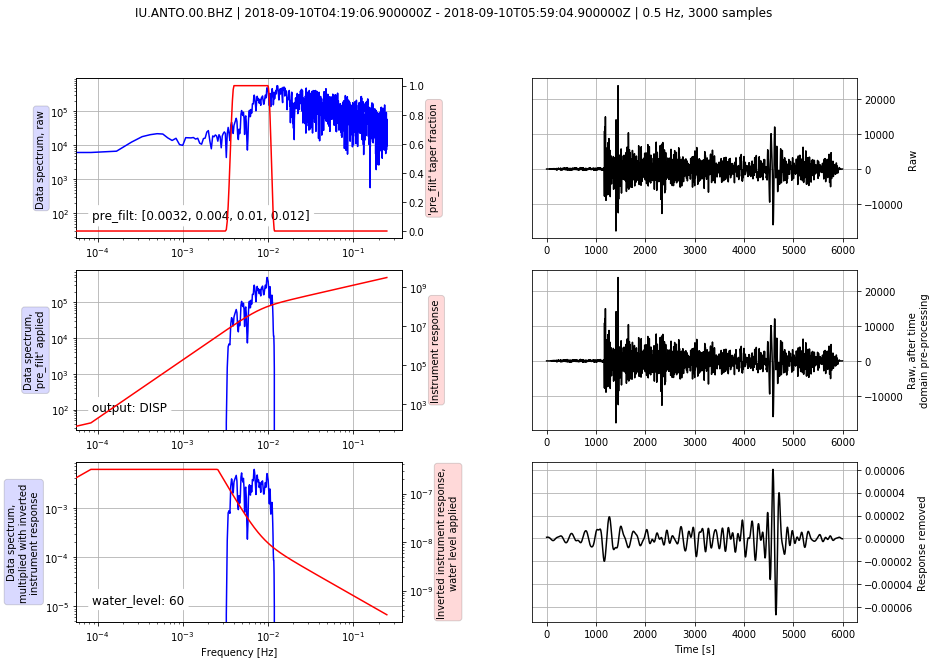

In [13]:
# Reading the instrument data
inv = obspy.read_inventory("./data/C201809100418A/stations/IU.ANTO.xml")
obsd.attach_response(inv)
# Remove mean and the linear trend
obsd.detrend("demean")
obsd.detrend("linear")
# Taper
obsd.taper(0.05)

min_period = 100
max_period = 250

# Define a pre-filter and remove the response function
pre_filt = [0.8*(1.0/max_period), (1.0/max_period), (1.0/min_period), 1.2*(1.0/min_period)]
obsd.remove_response(pre_filt=pre_filt, output="DISP",
                     water_level=60, plot=True)

Now if we plot the traces again we can see that, they are still not comparable. We need to apply the same filter to the synthetic data we used for observed data.

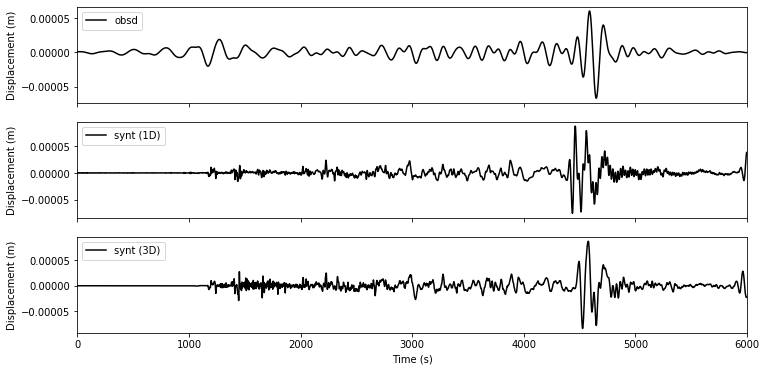

In [14]:
fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(12, 6))
axes[0].plot(obsd.times(), obsd.data, "k", label="obsd")
axes[0].legend(loc=2)
axes[0].set_ylabel("Displacement (m)")

axes[1].plot(synt1d.times(), synt1d.data, "k", label="synt (1D)")
axes[1].legend(loc=2)
axes[1].set_ylabel("Displacement (m)")

axes[2].plot(synt3d.times(), synt3d.data, "k", label="synt (3D)")
axes[2].set_ylabel("Displacement (m)")
axes[2].set_xlabel("Time (s)")
axes[2].set_xlim(0, 6000)

axes[2].legend(loc=2)

In [15]:
def sac_taper(tr):
    tr.detrend("demean")
    tr.detrend("linear")
    tr.taper(0.05)
    nfft = _npts2nfft(len(tr.data))
    data = np.fft.rfft(tr.data, nfft)
    fy = 1.0 / (tr.stats.delta * 2.0)
    freqs = np.linspace(0, fy, nfft//2+1)
    data *= cosine_sac_taper(freqs, flimit=pre_filt)
    tr.data = np.fft.irfft(data)[0:len(tr.data)]
    
# use sac taper on synthetic data
sac_taper(synt1d)
sac_taper(synt3d)

## Final Comparisons
Finally, we can compare the observed and synthetic data.

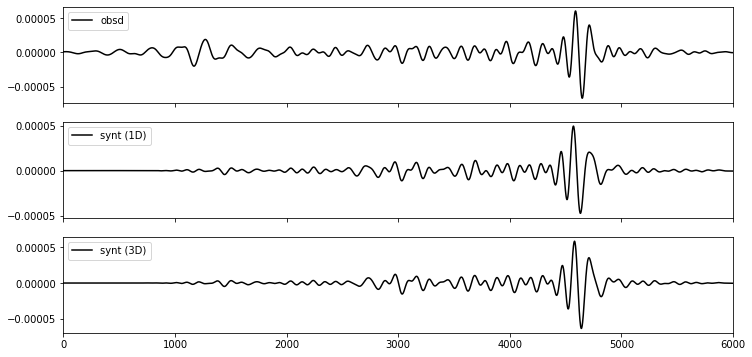

In [16]:
fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(12, 6))
axes[0].plot(obsd.times(), obsd.data, "k", label="obsd")
axes[0].legend(loc=2)

axes[1].plot(synt1d.times(), synt1d.data, "k", label="synt (1D)")
axes[1].legend(loc=2)

axes[2].plot(synt3d.times(), synt3d.data, "k", label="synt (3D)")
axes[2].set_xlim(0, 6000)
axes[2].legend(loc=2)

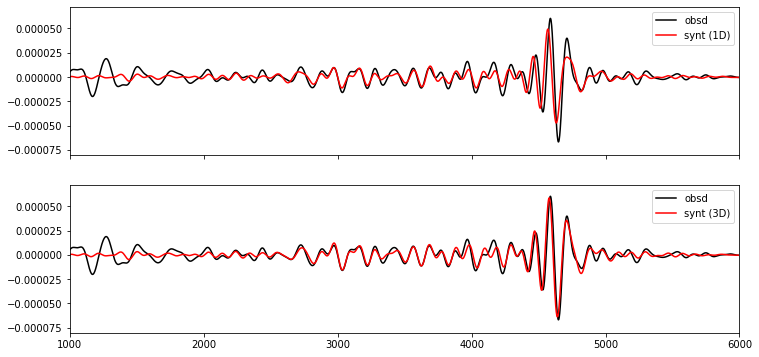

In [17]:
tmin, tmax = 1000, 6000
xmin, xmax = np.abs(obsd.times()-tmin).argmin(), np.abs(obsd.times()-tmax).argmin()
ymin, ymax = np.min(obsd.data[xmin:xmax])*1.2, np.max(obsd.data[xmin:xmax])*1.2

fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))
axes[0].plot(obsd.times(), obsd.data, "k", label="obsd")
axes[0].plot(synt1d.times(), synt1d.data, "r", label="synt (1D)")
axes[0].set_ylim(ymin, ymax)
axes[0].legend()

axes[1].plot(obsd.times(), obsd.data, "k", label="obsd")
axes[1].plot(synt3d.times(), synt3d.data, "r", label="synt (3D)")
axes[1].set_xlim(tmin, tmax)
axes[1].set_ylim(ymin, ymax)
axes[1].legend();

## Finding the time shift

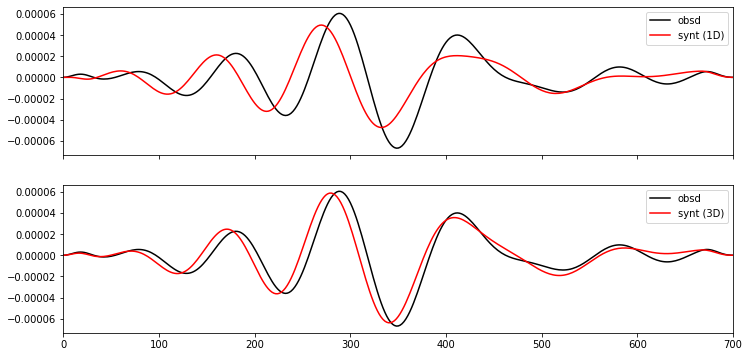

In [18]:
# Cut the data between 4300, 5000
tmin, tmax = 4300, 5000
obsd_sw = obsd.copy()
obsd_sw.trim(obsd_sw.stats.starttime+tmin, obsd_sw.stats.starttime+tmax)
obsd_sw.taper(0.05)

synt1d_sw = synt1d.copy()
synt1d_sw.trim(synt1d_sw.stats.starttime+tmin, synt1d_sw.stats.starttime+tmax)
synt1d_sw.taper(0.05)
    
synt3d_sw = synt3d.copy()
synt3d_sw.trim(synt3d_sw.stats.starttime+tmin, synt3d_sw.stats.starttime+tmax)
synt3d_sw.taper(0.05)


fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))
axes[0].plot(obsd_sw.times(), obsd_sw.data, "k", label="obsd")
axes[0].plot(synt1d_sw.times(), synt1d_sw.data, "r", label="synt (1D)")
axes[0].legend()

axes[1].plot(obsd_sw.times(), obsd_sw.data, "k", label="obsd")
axes[1].plot(synt3d_sw.times(), synt3d_sw.data, "r", label="synt (3D)")
axes[1].set_xlim(0, 700)
axes[1].legend();

In [19]:
def xcorr_shift(d, s):
    "Returns the time shift where the crosscorrelation is maximum"
    cc = np.correlate(d.data, s.data, mode="full")
    time_shift = cc.argmax() - len(d.data) + 1
    return time_shift*d.stats.delta

In [20]:
# Find the time shifts between the data
shift1d = xcorr_shift(obsd_sw, synt1d_sw)
shift3d = xcorr_shift(obsd_sw, synt3d_sw)

print(f"1D time shift: {shift1d:5.1f}\n3D time shift: {shift3d:5.1f} ")

1D time shift:  16.0
3D time shift:   8.0 


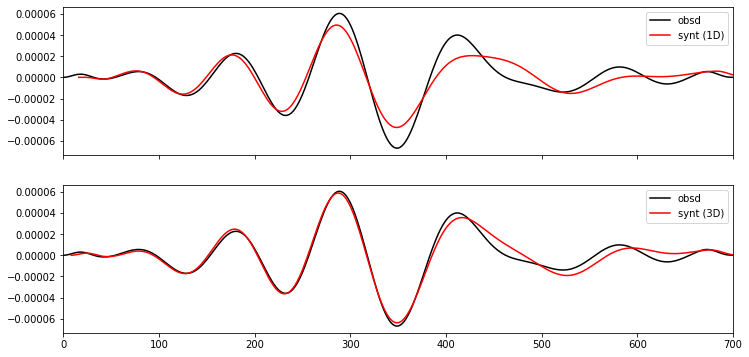

In [21]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))
axes[0].plot(obsd_sw.times(), obsd_sw.data, "k", label="obsd")
axes[0].plot(synt1d_sw.times()+shift1d, synt1d_sw.data, "r", label="synt (1D)")
axes[0].legend()

axes[1].plot(obsd_sw.times(), obsd_sw.data, "k", label="obsd")
axes[1].plot(synt3d_sw.times()+shift3d, synt3d_sw.data, "r", label="synt (3D)")
axes[1].set_xlim(0, 700)
axes[1].legend();